### Launches as API call to USDA, then plots data.

            year  crop  percent  week
date                                 
2008-06-08  2008  CORN       66    23
2008-06-15  2008  CORN       56    24
2008-06-22  2008  CORN       49    25
2008-06-29  2008  CORN       50    26
2008-07-06  2008  CORN       53    27
...          ...   ...      ...   ...
2020-06-14  2020  CORN       85    24
2020-06-21  2020  CORN       83    25
2020-06-28  2020  CORN       85    26
2020-07-05  2020  CORN       85    27
2020-07-12  2020  CORN       85    28

[277 rows x 4 columns]


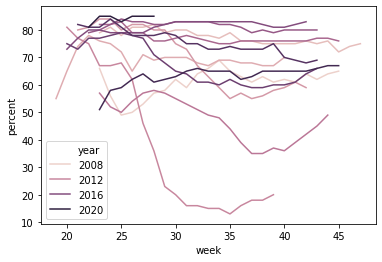

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import json

def crop_rating(year_param, unit_desc_param):

    ploads = {'format': 'JSON',
              'or_desc': 'CROPS',
              'domain_desc': 'TOTAL',
              'agg_level': 'STATE',
              'state_name': 'IOWA',
              'year__GE': year_param,
              'commodity_desc': 'CORN',
              'unit_desc': unit_desc_param,
              'statisticcat_desc': 'CONDITION'
              }
    # key (make a parameter)
    r = requests.get("https://quickstats.nass.usda.gov/api/api_GET/?key=1C757E50-5169-30CC-BEFD-40A5C3E2A43D", params=ploads)
    # execute get request
    dt1 = json.dumps(r.json(), indent=2, sort_keys=True)
    # make it json format
    obj1 = json.loads(dt1)

    # collect relevant data for each object created
    dt2 = []
    for i in obj1["data"]:
        dt2.append([i["year"], i["reference_period_desc"], i["commodity_desc"], i["Value"], i['unit_desc']])
    # convert from dictionary format to pandas
    dt3 = pd.DataFrame.from_dict(dt2)
    return dt3

# need to sum pct good and excellent
desc1 = ['PCT EXCELLENT', 'PCT GOOD']

# create separate lists for each description (good, excellent)
df100 = []
for desc in desc1:
    df100.append(crop_rating(2008, desc))

# combine dataframes
df10 = pd.concat(df100)
df10.columns = ["year", "week", "crop", "percent", "quality"]
df10["percent"] = df10["percent"].astype(int)
# sum excellent and pct good
df11 = df10.groupby(['year', 'week', 'crop']).agg({'percent': 'sum'}).reset_index()

# clean up columns to create date object
df11['weekofyear'] = df11['week'].map(lambda x: x.lstrip('WEEK #'))
# # year is an int, so it week, make year 1990 to 199000 and add week of year so 199032 (32 week)
df11["yearweek"]  = df11.year.astype(int) * 100 + df11.weekofyear.astype(int)

# format to datetime
df11['date'] = pd.to_datetime(df11.yearweek.astype(str) + '0', format='%Y%W%w')
# set date as index
df12 = df11.set_index("date")
# drop unnecessary columns
df12 = df12.drop(["week","weekofyear", "yearweek"], axis = 1)

# create week and year columns for plotting purposes only
df12['week'] = pd.to_datetime(df12.index).week.astype(int)
df12['year'] = pd.to_datetime(df12.index).year.astype(int)
print(df12)
# plot week for each year, put in one figure
sns.lineplot(x='week',y='percent',hue='year',data=df12)
plt.show()
